<a href="https://colab.research.google.com/github/kridtapon/WFO-New-Future-Trend-Crossover/blob/main/WFO_New_Future_Trend_Crossover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.6 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
<ipython-input-5-4e91ed19e7d0>:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-4e91ed19e7d0>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-4e91ed19e7d0>:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in


Walk-Forward Optimization Results:
   Year       Best_Params  Test_Return
0  2020    (6, 91, 15, 1)     0.364519
1  2021    (1, 76, 18, 8)    -0.037077
2  2022  (46, 51, 16, 13)     0.220063
3  2023  (46, 51, 16, 13)     0.194875
4  2024   (41, 51, 15, 8)     0.160910
5  2025   (41, 56, 16, 6)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           232002.133234
Total Return [%]                       132.002133
Benchmark Return [%]                   145.632617
Max Gross Exposure [%]                      100.0
Total Fees Paid                      11088.931376
Max Drawdown [%]                        15.496844
Max Drawdown Duration                       193.0
Total Trades                                   36
Total Closed Trades                            36
Total Open Trades                        

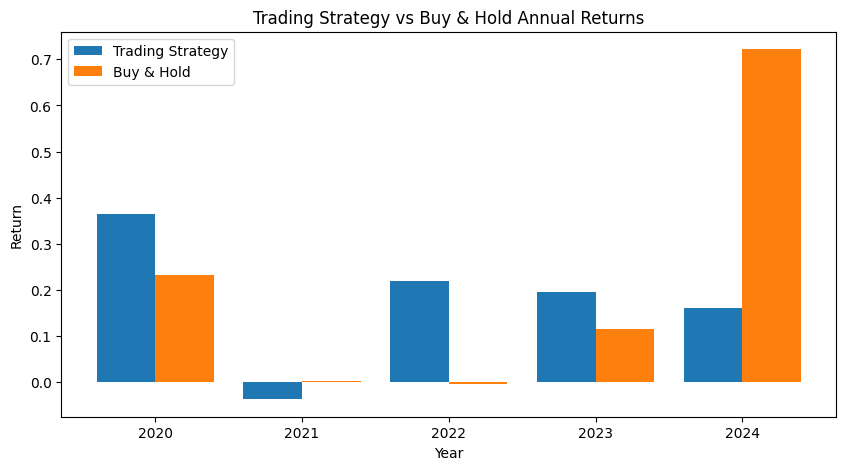

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Displaced Moving Averages (DMA)
def calculate_dma(df, period, shift):
    return df['Close'].rolling(window=period).mean().shift(shift)

# Walk-forward optimization with Displaced Moving Averages (DMA)
def walk_forward_optimization_dma(df, start_year, end_year):
    results = []

    # Define dynamic ranges for DMA parameters
    dma_fast_period_range = range(1, 52, 5)  # Range for fast DMA periods
    dma_slow_period_range = range(51, 102, 5)  # Range for slow DMA periods
    dma_fast_shift_range = range(1, 21)  # Range for fast DMA shifts
    dma_slow_shift_range = range(1, 21)  # Range for slow DMA shifts

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of DMA parameters
        for params in itertools.product(dma_fast_period_range, dma_slow_period_range, dma_fast_shift_range, dma_slow_shift_range):
            fast_period, slow_period, fast_shift, slow_shift = params

            # Calculate DMA indicators on the training data
            train_data['DMA_fast'] = calculate_dma(train_data, period=fast_period, shift=fast_shift)
            train_data['DMA_slow'] = calculate_dma(train_data, period=slow_period, shift=slow_shift)

            # Generate entry and exit signals based on DMA
            entries = train_data['DMA_fast'] > train_data['DMA_slow']
            exits = train_data['DMA_fast'] < train_data['DMA_slow']

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (fast_period, slow_period, fast_shift, slow_shift)

        # Test with the best parameters on the test data
        # Extend the data range to include the previous year for indicator calculation
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply DMA indicators
        yearly_data['DMA_fast'] = calculate_dma(yearly_data, best_params[0], best_params[2])
        yearly_data['DMA_slow'] = calculate_dma(yearly_data, best_params[1], best_params[3])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = yearly_data['DMA_fast'] > yearly_data['DMA_slow']
        exits = yearly_data['DMA_fast'] < yearly_data['DMA_slow']

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'WMT'  # GDDY HWM! SYF! TPL! UAL! WMT!
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_dma(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply DMA indicators
    yearly_data['DMA_fast'] = calculate_dma(yearly_data, params[0], params[2])
    yearly_data['DMA_slow'] = calculate_dma(yearly_data, params[1], params[3])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = yearly_data['DMA_fast'] > yearly_data['DMA_slow']
    exits = yearly_data['DMA_fast'] < yearly_data['DMA_slow']

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [6]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,245632.617258
Total Return [%],145.632617
Benchmark Return [%],145.632617
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],25.739681
